In [25]:
import pandas as pd
import nltk
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import itertools
from wordcloud import WordCloud, STOPWORDS

from src.features.preprocess_old import PreProcess

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

from gensim import corpora, models
import gensim

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/prestonstringham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prestonstringham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def remove_escape_chars(s):
    """
    Helper function used to replace hashtags with empty string
    """
    if isinstance(s, str):
        return re.sub(r'\n', '', s)
    else:
        return s
def filter_urls(s):
    """
    Helper function used to replace URLs with empty string
    """
    if isinstance(s, str):
        return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', s, flags=re.MULTILINE)
    else:
        return s

## EDA Posts

In [3]:
cs_posts = pd.read_csv('../data/raw/computerscience_hot_posts.csv')
cs_comments = pd.read_csv('../data/raw/computerscience_hot_comments.csv')
aita_posts = pd.read_csv('../data/raw/AmItheAsshole_hot_posts.csv')
aita_comments = pd.read_csv('../data/raw/AmItheAsshole_hot_comments.csv')
antiwork_posts = pd.read_csv('../data/raw/antiwork_hot_posts.csv')
antiwork_comments = pd.read_csv('../data/raw/antiwork_hot_comments.csv')
loseit_posts = pd.read_csv('../data/raw/loseit_hot_posts.csv')
loseit_comments = pd.read_csv('../data/raw/loseit_hot_comments.csv')
music_posts = pd.read_csv('../data/raw/music_hot_posts.csv')
music_comments = pd.read_csv('../data/raw/music_hot_comments.csv')
nsq_posts = pd.read_csv('../data/raw/NoStupidQuestions_hot_posts.csv')
nsq_comments = pd.read_csv('../data/raw/NoStupidQuestions_hot_comments.csv')

In [4]:
posts_dic = {'cs': cs_posts, 'aita': aita_posts, 'antiwork': antiwork_posts, 'loseit': loseit_posts, 'music': music_posts, 'nsq': nsq_posts}
comments_dic = {'cs': cs_comments, 'aita': aita_comments, 'antiwork': antiwork_comments, 'loseit': loseit_comments, 'music': music_comments, 'nsq': nsq_comments}

In [7]:
for i in posts_dic.keys():
    posts_dic[i] = PreProcess.preprocess(posts_dic[i], 'body')
    for j in range(len(posts_dic[i].index)):
        posts_dic[i].at[j, 'body_string'] = ' '.join([str(elem) for elem in posts_dic[i].at[j, 'body_stem']])
    posts_dic[i]['body'] = posts_dic[i]['body'].apply(remove_escape_chars)
    posts_dic[i]['body'] = posts_dic[i]['body'].apply(filter_urls)

In [8]:
posts_dic['cs']

,post_id,title,score,upvote_ratio,subreddit,url,num_comments,body,created,body_word_token,body_filtered,body_stem,body_string
0,spnpvh,"Books about CS (Non-Fiction, Fiction, Biograph...",18,0.96,computerscience,https://www.reddit.com/r/computerscience/comme...,5,Looking for books related to computer science ...,1.644546e+09,"[Looking, for, books, related, to, computer, s...","[looking, books, related, computer, science, l...","[look, book, relat, comput, scienc, learn, mat...",look book relat comput scienc learn materi bio...
1,spml7t,ideas for valentines day coding related gifts?,5,0.86,computerscience,https://www.reddit.com/r/computerscience/comme...,7,anyone have any idea for a cute gift i can mak...,1.644543e+09,"[anyone, have, any, idea, for, a, cute, gift, ...","[anyone, idea, cute, gift, make, programming, ...","[anyon, idea, cute, gift, make, program, id, r...",anyon idea cute gift make program id realli ap...
2,sp7b3q,Prim's Algorithm produces a Spanning Tree,31,0.97,computerscience,https://www.reddit.com/r/computerscience/comme...,2,I have been studing Algorithms using Stanford ...,1.644502e+09,"[I, have, been, studing, Algorithms, using, St...","[studing, algorithms, using, stanford, algorit...","[stude, algorithm, use, stanford, algorithm, c...",stude algorithm use stanford algorithm cours c...
3,spay93,Where to learn Data Structures & Algorithms fu...,13,0.93,computerscience,https://www.reddit.com/r/computerscience/comme...,3,I want to get into coding interviews but first...,1.644512e+09,"[I, want, to, get, into, coding, interviews, b...","[want, get, coding, interviews, first, want, l...","[want, get, code, interview, first, want, lear...",want get code interview first want learn found...
4,sprt86,Adding class projects to resume,1,1.00,computerscience,https://www.reddit.com/r/computerscience/comme...,0,"When adding class projects to my resume, shoul...",1.644559e+09,"[When, adding, class, projects, to, my, resume...","[adding, class, projects, resume, include, cla...","[ad, class, project, resum, includ, class, lis...",ad class project resum includ class list tikta...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,qb5blt,"From a memory/efficiency point of view, is the...",0,0.20,computerscience,https://www.reddit.com/r/computerscience/comme...,2,"I lost my wallet recently, containing my debit...",1.634624e+09,"[I, lost, my, wallet, recently, ,, containing,...","[lost, wallet, recently, containing, debit, cr...","[lost, wallet, recent, contain, debit, credit,...",lost wallet recent contain debit credit card l...
496,qabacx,Extended use of math in computer science?,71,0.93,computerscience,https://www.reddit.com/r/computerscience/comme...,33,Hey I’m kind of new to computer science learni...,1.634517e+09,"[Hey, I, ’, m, kind, of, new, to, computer, sc...","[hey, kind, new, computer, science, learning, ...","[hey, kind, new, comput, scienc, learn, one, t...",hey kind new comput scienc learn one thing kee...
497,qah5lk,Do computers calculate irrational and rational...,14,0.87,computerscience,https://www.reddit.com/r/computerscience/comme...,9,,1.634539e+09,[],[],[],
498,qakzly,Wrong Algorithm ? I found this algorithm on ge...,5,0.73,computerscience,/r/AskComputerScience/comments/qakxks/wrong_al...,5,,1.634557e+09,[],[],[],


In [16]:
def eda(df, pre='body', subreddit=''):
    
    print('Subreddit: ',  subreddit)
    print("Number of Posts:",df.shape[0])
    
    all_words = [word for tokens in df[pre + '_filtered'] for word in tokens]
    post_lengths = [len(tokens) for tokens in df[pre + '_filtered']]
    vocab = sorted(list(set(all_words)))

    print('{} words total (after preprocessing), with a vocabulary size of {}'.format(len(all_words), len(vocab)))
    print('Max post length is {}'.format(max(post_lengths)))
    
    flat_words = [item for sublist in df[pre + '_filtered'] for item in sublist]
    word_freq = FreqDist(flat_words)
    fdf = pd.DataFrame(word_freq.most_common(20), columns=['word', 'frequency'])
    fdf.plot(kind='bar', x='word', rot=70, title=subreddit)

Subreddit:  cs
Number of Posts: 500
22590 words total (after preprocessing), with a vocabulary size of 5092
Max post length is 399
Subreddit:  aita
Number of Posts: 752
129147 words total (after preprocessing), with a vocabulary size of 10883
Max post length is 521
Subreddit:  antiwork
Number of Posts: 942
51350 words total (after preprocessing), with a vocabulary size of 7990
Max post length is 1276
Subreddit:  loseit
Number of Posts: 788
86729 words total (after preprocessing), with a vocabulary size of 9270
Max post length is 1262
Subreddit:  music
Number of Posts: 394
9432 words total (after preprocessing), with a vocabulary size of 3480
Max post length is 699
Subreddit:  nsq
Number of Posts: 971
20075 words total (after preprocessing), with a vocabulary size of 5490
Max post length is 279


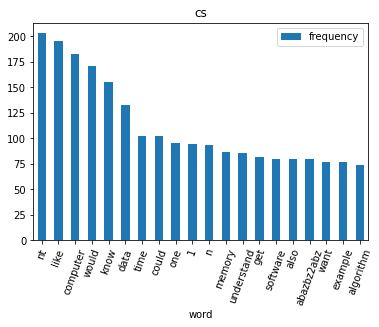

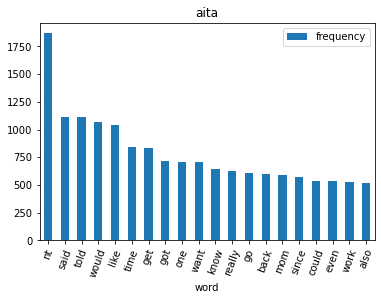

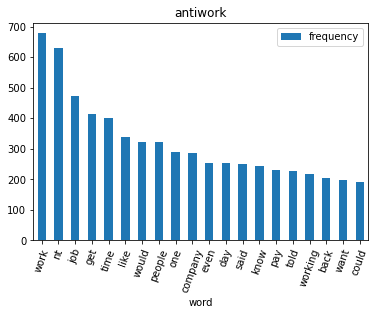

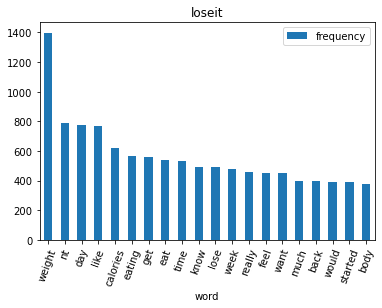

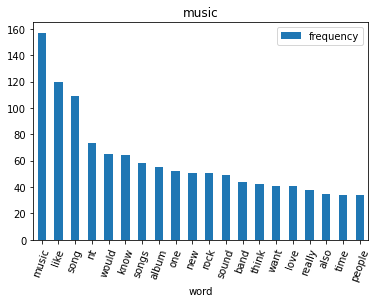

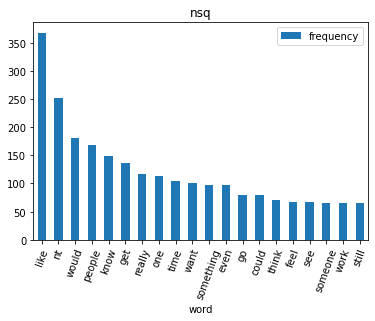

In [17]:
for i in posts_dic.keys():
    eda(posts_dic[i], subreddit=i)

## EDA Comments 

In [18]:
comments_dic['cs'].head()

,post_id,comment_id,parent_id,comment,up_vote_count,down_vote_count,controversiality,total_awards_received,score,is_locked,is_collapsed,is_submitter,created_utc
0,spnpvh,hwgsuow,t3_spnpvh,"Xerox PARC didn't just invent the GUI, they in...",2,0,0,0,2,False,False,False,1.644555e+09
1,spnpvh,hwgdcg1,t3_spnpvh,I recently went through The Innovators. It giv...,3,0,0,0,3,False,False,False,1.644547e+09
2,spnpvh,hwgslxi,t3_spnpvh,The Unicorn Project is pretty good.,1,0,0,0,1,False,False,False,1.644555e+09
3,spnpvh,hwgtesm,t3_spnpvh,For fiction stories that arguably contain comp...,1,0,0,0,1,False,False,False,1.644555e+09
4,spnpvh,hwgygdz,t3_spnpvh,Cliff Stoll's [*Cuckoo's Egg*](https://en.wiki...,1,0,0,0,1,False,False,False,1.644558e+09


In [19]:
for i in comments_dic.keys():
    comments_dic[i] = PreProcess.preprocess(comments_dic[i], 'comment')
    for j in range(len(comments_dic[i].index)):
        comments_dic[i].at[i, 'comment_string'] = ' '.join([str(elem) for elem in comments_dic[i].at[j, 'comment_stem']])  

In [271]:
# print("For post_id = n2n0ax:")
# eda(preprocessed_df_comments[preprocessed_df_comments.post_id == 'n2n0ax'], "comment")

In [272]:
# display(preprocessed_df[preprocessed_df.post_id == 'n2n0ax'])
# print("\n>>>>Title: \n", preprocessed_df[preprocessed_df.post_id == 'n2n0ax'].title[0])
# print("\n>>>>Body: \n",preprocessed_df[preprocessed_df.post_id == 'n2n0ax'].body[0])

## BERTopic on Posts Text (Body)

In [21]:
body_umap_params = {
    'n_neighbors':5,
    'n_components': 5,
    'min_dist': 0.0,
    'metric': 'cosine',
    'low_memory': False
}
body_hdb_params = {
    'min_cluster_size': 5,
    'min_samples': 4,
    'metric': 'euclidean',
    'cluster_selection_method': 'eom',
    'prediction_data': True
}
body_model_params = {
    'min_topic_size': 3,
    'top_n_words': 5,
    'n_gram_range': (1,2), 
    'calculate_probabilities': True,
    'verbose': True
}

In [22]:
def train_bert(df, column, umap_params, hdb_params, model_params):
    umap_model = UMAP(**umap_params)
    hdbscan_model = HDBSCAN(**hdb_params)
    topic_model = BERTopic(**model_params, umap_model=umap_model, hdbscan_model=hdbscan_model)
    topics, probs = topic_model.fit_transform(df[column])
    freq = topic_model.get_topic_info()
    docs = topic_model.get_representative_docs()
    topic_names = []
    for i in topics:
        topic_names.append(list(freq[freq['Topic'] == i]["Name"])[0])
    df['topic_label'] = topics
    df['topic_name'] = topic_names
    return topic_model, freq, df

In [26]:
post_model_topic_model_dic = {}
post_model_freq_dic = {}
post_model_df_dic = {}
for i in posts_dic.keys():
    post_model_topic_model_dic[i], post_model_freq_dic[i], post_model_df_dic[i] = train_bert(posts_dic[i], 'body', body_umap_params, body_hdb_params, body_model_params)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2022-02-11 02:35:44,304 - BERTopic - Transformed documents to Embeddings
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2022-02-11 02:35:50,518 - BERTopic - Reduced dimensionality with UMAP
2022-02-11 02:35:50,578 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2022-02-11 02:37:02,757 - BERTopic - Transformed documents to Embeddings
2022-02-11 02:37:05,427 - BERTopic - Reduced dimensionality with UMAP
2022-02-11 02:37:05,554 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

2022-02-11 02:37:42,302 - BERTopic - Transformed documents to Embeddings
2022-02-11 02:37:46,235 - BERTopic - Reduced dimensionality with UMAP
2022-02-11 02:37:46,333 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

2022-02-11 02:38:50,532 - BERTopic - Transformed documents to Embeddings
2022-02-11 02:38:53,179 - BERTopic - Reduced dimensionality with UMAP
2022-02-11 02:38:53,311 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2022-02-11 02:39:11,491 - BERTopic - Transformed documents to Embeddings
2022-02-11 02:39:13,583 - BERTopic - Reduced dimensionality with UMAP
2022-02-11 02:39:13,621 - BERTopic - Clustered UMAP embeddings with HDBSCAN


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

2022-02-11 02:39:37,975 - BERTopic - Transformed documents to Embeddings
2022-02-11 02:39:41,123 - BERTopic - Reduced dimensionality with UMAP
2022-02-11 02:39:41,292 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [33]:
num_post_topics = {}
print('Number of topics found per subreddit:')
for i in post_model_freq_dic.keys():
    num_post_topics[i] = len(post_model_freq_dic[i])
    print(i, len(post_model_freq_dic[i]))

Number of topics found per subreddit:
cs 33
aita 54
antiwork 34
loseit 56
music 23
nsq 60


In [36]:
eda_df = pd.DataFrame.from_dict(num_post_topics, orient='index')

In [42]:
eda_df.columns = ['num_posts_topics_found']

In [43]:
eda_df

,num_posts_topics_found
cs,33
aita,54
antiwork,34
loseit,56
music,23
nsq,60


In [57]:
eda_df['posts_word_count'] = 0
eda_df['posts_max_length'] = 0
eda_df['posts_vocab_size'] = 0
for i in posts_dic.keys():
    eda_df['posts_word_count'].loc[i] = len([word for tokens in posts_dic[i]['body_filtered'] for word in tokens])
    eda_df['posts_max_length'].loc[i] = np.max([len(tokens) for tokens in posts_dic[i]['body_filtered']])
    eda_df['posts_vocab_size'].loc[i] = len(sorted(list(set([word for tokens in posts_dic[i]['body_filtered'] for word in tokens]))))

In [75]:
eda_df

,num_posts_topics_found,posts_word_count,posts_vocab_size,posts_max_length
cs,33,22590,5092,399
aita,54,129147,10883,521
antiwork,34,51350,7990,1276
loseit,56,86729,9270,1262
music,23,9432,3480,699
nsq,60,20075,5490,279


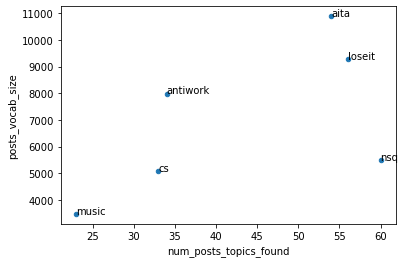

In [73]:
fig, ax = plt.subplots()
eda_df.plot(x='num_posts_topics_found', y='posts_vocab_size', kind='scatter', ax=ax)
for k, v in eda_df[['num_posts_topics_found', 'posts_vocab_size']].iterrows():
    ax.annotate(k, v)

Subreddits with higher number of topics generally have higher vocabularies, which makes sense, but this is not always the case. When it is not the case, like antiwork, is that indicative of repetitive posts/topics of discussion within subreddit?

In [76]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [77]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

In [78]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [79]:
for i in comments_dic.keys():
    comments_dic[i]['sentiment'] = comments_dic[i]['comment'].apply(lambda x: sentiment_score(x[:512]))

TypeError: 'float' object is not subscriptable